In [117]:
# import the libraries
import torch
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import cv2      # open CV

import pandas as pd
import numpy as np


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

from torchcam.methods import CAM, GradCAM, GradCAMpp, ISCAM, LayerCAM, SSCAM, ScoreCAM, SmoothGradCAMpp, XGradCAM



# CAM GradCAM GradCAMpp ISCAM LayerCAM SSCAM ScoreCAM SmoothGradCAMpp XGradCAM

# CAM_extractor = CAM(model)
# GradCAM_extractor = GradCAM(model)
# GradCAMpp_extractor = GradCAMpp(model)
# ISCAM_extractor = ISCAM(model)
# LayerCAM_extractor = LayerCAM(model)
# SSCAM_extractor = SSCAM(model)
# ScoreCAM_extractor = ScoreCAM(model)
# SmoothGradCAMpp_extractor = SmoothGradCAMpp(model)
# XGradCAM_extractor = XGradCAM(model)

In [118]:
import torchvision.models as models

googlenet = models.squeezenet1_1(pretrained=True)

print(googlenet)

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): MaxPool2d

d:\Anaconda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Anaconda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [119]:
image_results = []
cam_results = []

for i, method in enumerate([CAM, GradCAM, GradCAMpp, LayerCAM, ScoreCAM, SmoothGradCAMpp, XGradCAM, ISCAM,]):

    # Define your model
    from torchvision.models import googlenet
    model = googlenet(pretrained=True).eval().to(device)
    print(method)
    
    
    extractor = method(model)
    
    
    # Scale, Crop, Turn Tensor, Normalize
    from torchvision import transforms
    test_transform = transforms.Compose([transforms.Resize(256),
                                        transforms.CenterCrop(224),
                                        transforms.ToTensor(),
                                        transforms.Normalize(
                                            mean=[0.485, 0.456, 0.406], 
                                            std=[0.229, 0.224, 0.225])
                                        ])

    # test image
    img_path = 'test_img/1280.jpg'
    
    # image preprocessing
    img_pil = Image.open(img_path)
    input_tensor = test_transform(img_pil).unsqueeze(0).to(device)

    df = pd.read_csv('imagenet_class_index.csv')

    pred_logits = model(input_tensor) # The output has unnormalized scores.

    # use openCV to load image
    img_bgr = cv2.imread(img_path)

    # choose top n probabilities
    n = 1
    pred_top_n = torch.topk(pred_logits, n) # returns the k largest elements of the given input tensor long a given dimension.
    pred_ids = pred_top_n[1].detach().cpu().numpy().squeeze().item()

    # calculate confidences
    confs = pred_top_n[0].cpu().detach().numpy().squeeze()   

    ### CAM
    from torchcam.utils import overlay_mask
    activation_map_raw = extractor(pred_ids, pred_logits)
    activation_map = activation_map_raw[0][0].detach().cpu().numpy()
    result = overlay_mask(img_pil, Image.fromarray(activation_map), alpha=0.7) # overlay a colormapped mask on a background image 

    # load labels
    df = pd.read_csv('imagenet_class_index.csv')
    idx_to_labels = {}
    idx_to_labels_cn = {}
    for idx, row in df.iterrows():
        idx_to_labels[row['ID']] = row['class']
        idx_to_labels_cn[row['ID']] = row['Chinese']

    from PIL import Image, ImageDraw, ImageFont
    import matplotlib.pyplot as plt
    font_size = 40
    font = ImageFont.truetype("arial.ttf", font_size)

    draw = ImageDraw.Draw(result)
    text_pred = 'Pred Class: {}'.format(idx_to_labels[pred_ids])
    draw.text((50, 100), text_pred, font=font, fill=(255, 0, 0, 1))


    cam_results.append(activation_map_raw[0].squeeze(0).cpu().numpy())
    image_results.append(result)

d:\Anaconda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<class 'torchcam.methods.activation.CAM'>


d:\Anaconda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Anaconda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<class 'torchcam.methods.gradient.GradCAM'>


d:\Anaconda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Anaconda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<class 'torchcam.methods.gradient.GradCAMpp'>


d:\Anaconda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Anaconda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<class 'torchcam.methods.gradient.LayerCAM'>


d:\Anaconda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Anaconda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<class 'torchcam.methods.activation.ScoreCAM'>


d:\Anaconda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Anaconda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<class 'torchcam.methods.gradient.SmoothGradCAMpp'>


d:\Anaconda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Anaconda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<class 'torchcam.methods.gradient.XGradCAM'>


d:\Anaconda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Anaconda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<class 'torchcam.methods.activation.ISCAM'>


In [120]:
import torchvision.models as models

googlenet = models.googlenet(pretrained=True)


d:\Anaconda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Anaconda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


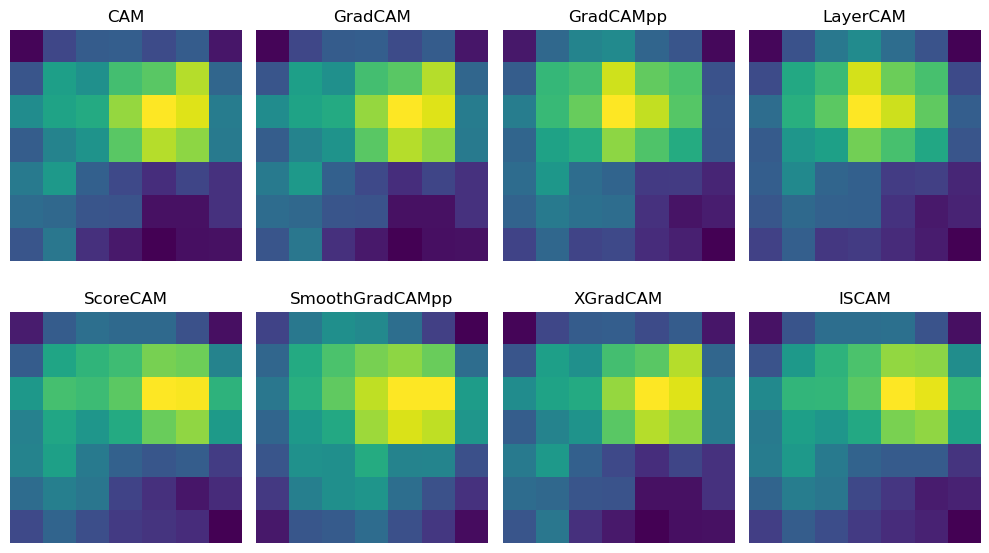

In [121]:
cam_methods = ['CAM', 'GradCAM', 'GradCAMpp', 'LayerCAM', 'ScoreCAM', 'SmoothGradCAMpp', 'XGradCAM', 'ISCAM',]
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(10, 6))

for i in range(2):
    for j in range(4):
        if i * 3 + j < len(cam_results):
            index = i * 4 + j
            axes[i, j].imshow(cam_results[index], cmap='viridis')
            axes[i, j].axis('off')
            axes[i, j].set_title(cam_methods[index])

plt.tight_layout()
plt.show()

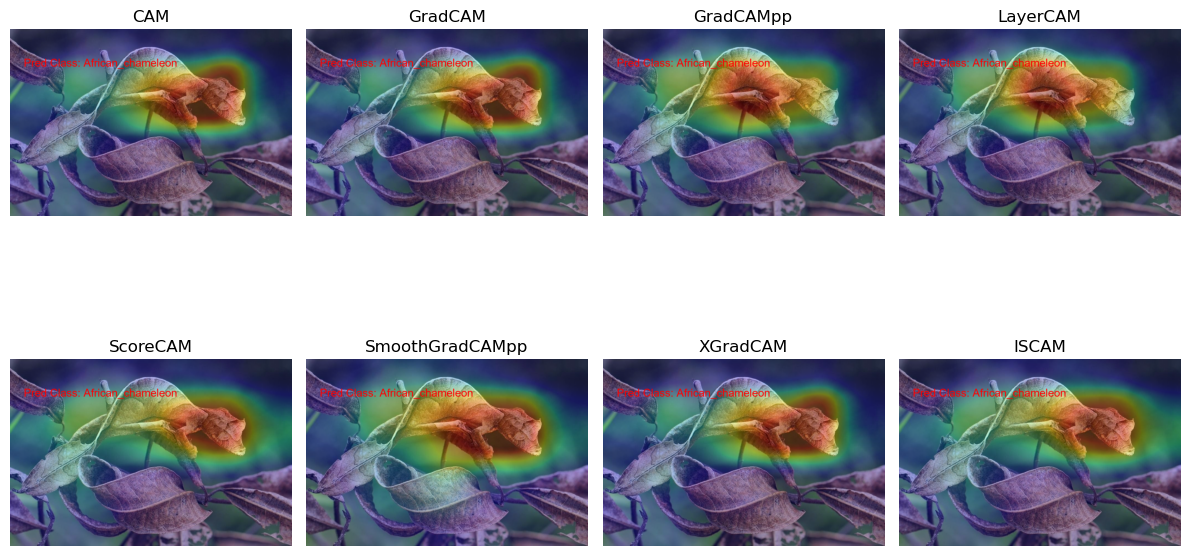

In [122]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 8))

for i in range(2):
    for j in range(4):
        if i * 3 + j < len(image_results):
            index = i * 4 + j
            axes[i, j].imshow(image_results[index], cmap='viridis')
            axes[i, j].axis('off')
            axes[i, j].set_title(cam_methods[index])
plt.tight_layout()
plt.show()